# Quantum Practical Assignment
## TP2 de Interação e Concorrência


### Grupo 10 

   - Luís Miguel Mendonça Almeida - A84180
   - João Pedro Martins Montrezol Camilo Antunes - A86813


## Introdução
- breve introdução

In [4]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
from math import floor
from IPython.display import HTML
%matplotlib inline

## Grover Algorithm

Consideremos o problema de encontrar um item numa lista não estruturada (i.e. sem ordem). Uma abordagem num contexto de computação clássica seria percorrer toda esta lista até encontrar o item, o que significa que é possível resolver este problema em O(N) passos.

<img src="images/linear_search.gif" width="500" align="center">


No entanto, utilizando um computador quântico, é possível resolver este problema com o algoritmo de Grover em O($\sqrt{N}$) passos, o que é uma melhoria substancial em relação ao paradigma clássico de computação.


O primeiro passo para entendermos o algoritmo de Grover é entender como representar uma lista não estruturada no paradigma quântico. Podemos olhar para o espaço de estados representáveis com $N$ qubits como sendo os elementos da nossa lista, obtendo assim $2^{N}-1$ elementos. Por exemplo, suponhamos que temos $3$ qubits. Assim, os elementos da lista serão: $|000\rangle , |001\rangle , |010\rangle , |011\rangle , |100\rangle , |101\rangle , |111\rangle$. Ora, se ao medirmos o estado de cada um dos qubits tivermos a mesma probabilidade de obter qualquer um dos elementos da lista, então esta estará desordenada. 

O algoritmo de Grover é constituído por $3$ etapas:

- Inicialização do circuito para que todos os estados possíveis de *input* tenham a mesma amplitude

- Oráculo que altera a fase do estado (i.e. elemento) que queremos encontrar para um número negativo

- Amplificação da probabilidade de, ao medirmos o estado, este colapsar naquele que tem fase negativa, alterando-a para positiva


<img src="https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg" width="800 px" align="center">


### Inicialização

Para darmos a mesma amplitude para todos os estados possíveis de *input*, começamos por passar todos os qubits por uma gate de Hadamard


### Oráculo

Nesta etapa queremos construir um oráculo que identifique corretamente o estado (i.e. elemento) que estamos a procurar e altere a sua fase de forma a que esta fique negativa, mantendo positivas as fases de todos os outros estados. No nosso caso queremos encontrar o valor $|010\rangle$, pelo que uma implementação do oráculo pedido seria:

<img src="images/gate_ccz.png" width="200" align="center">

### Amplificação

Queremos agora amplificar a probabilidade de, ao medirmos o estado dos qubits, este colapsar no estado que tem fase negativa. Para este efeito, aplicamos uma gate de Hadamard, seguida de uma gate X, seguidos da gate $C^{N}Z$ (decomposta) e novamente uma gate X e H, para todos os qubits. Não nos devemos esquecer que esta etapa inverte novamente a fase do estado que queremos encontrar, pelo que no fim deste processo ficará positiva.

Assim, seguindo este raciocínio, podemos repetir as etapas de Oráculo e Amplificação para aumentarmos cada vez mais a probabilidade do estado dos qubits colapsar no elemento desejado. No entanto, temos de ter cuidado em não realizar iterações a mais pois tal pode resultar num decréscimo desta probabilidade. O número ideal de vezes que se repetem estas etapas é usualmente $\sqrt(N)$, podendo este número ser ligeiramente alterado em cada caso específico.


## Código

A fim de aplicar o algoritmo descrito no último tópico, será então desenvolvida uma função de ordem superior. A qual chamaremos `oracleHandler(nQBits)`. 

Esta função receberá como parâmetro o número de QBits que será utilizado no circuito *target* da aplicação final. Como resultado, tal função retornará uma outra função, esta última pronta a receber um circuito *target* e um *pattern* a ser procurado.

Prosseguiremos então por explicar as etapas da função de ordem superior desenvolvida:


In [ ]:
applications = floor(2**(nQBits/2))
auxN = max(nQBits - 3,0)

Inicialmente calcula-se o número recomendado de aplicações do algoritmo. Como referido, o valor "ideal" teórico é $\sqrt(N)$, sendo no caso requerido, $N = 2^{nQbits}$.

Além disso é calculado neste ponto também, o número de QBits auxiliares para se realizar a aplicação do algoritmo. Este valor é calculado consoante a maneira com que os *gates* $c^{n}Z$ são desenvolvidos. 

Nas nossas aplicações o valor de gates auxiliares é dado simplesmente pela subtração de $3$ a `nQbits`, em outras versões o valor a ser subtraído poderia ser $2$, pelo uso explícito do gate $cZ$ como apresentado mais adiante.

Passaremos agora ao desenvolvimento da função de aplicação do oráculo:

In [3]:
    def searchPat(circuit,QBits,pattern):
        for i,t in enumerate(pattern):
            if t == '0':
                circuit.x(QBits[len(pattern)- 1 - i])
        pass

Esta primeira função aninhada dentro da função de ordem superior desenvolvida consistirá no início da aplicação do oráculo. Por estarmos lidando com funções de ordem superior, escalonáveis, esta função teve de ser definida internamente à função `oracleHandler(nQBits)`(assim como as próximas a serem apresentadas) para garantir sua parâmetrização consoante o número de bits do circuito. 

Esta função tratará de "selecionar" os valores que ativarão os *gates* $c^{n}Z$ a seguir. Assim, tal função irá aplicar um *gate* $X$ negando os QBits que estejam em posições delimitadas por $0$s no pattern a ser buscado. Tendo em atenção que pattern ainda não será um argumento da aplicação da função, mas sim, de uma aplicação futura da função resultante desta operação.

A função ainda leva em conta a "inversão" na ordem dos bits realizada, iterando os valores corretamente através do cálculo de índice realizado.

A seguir apresenta-se a função aninhada de maior importância na composição do algoritmo requerido,

In [ ]:
    def fullCnZ(circuit,QBits,nQBits,auxQBits):

        auxLen = max(nQBits - 3,0)

        if (nQBits > 2):
            finals = [QBits[0],QBits[1]]

        for x in range(auxLen):
            circuit.ccx(finals[-2],finals[-1],auxQBits[x])
            finals += [auxQBits[x]]
            finals += [QBits[x+2]]           

        
        #Z - CZ - CCZ
        #----------------------------------#
        switch={
            1: (lambda: circuit.x(QBits[0])),
            2: (lambda: circuit.cx(QBits[0],QBits[1])),
            'default': (lambda: circuit.ccx(finals[-2],finals[-1],QBits[nQBits-1])),
            }

        circuit.h(QBits[nQBits-1])
        switch.get(nQBits,switch['default'])()
        circuit.h(QBits[nQBits-1])
        #----------------------------------#
        
        finals.pop()

        while len(finals) > 1:
            tgt = finals.pop()
            q2 = finals.pop()
            q1 = finals[-1]
            circuit.ccx(q1,q2,tgt)
        
        pass

A função consistirá em formar o *gate* $c^{nQBits}Z$ necessário para a aplicação do algoritmo. Para tanto, a função inicia por julgar se bits auxiliares serão necessários. Realizando uma de quatro estratégias, 

- O circuito só possui $1$ QBit: $1$ único gate $Z$ simples é aplicado;

- O circuito só possui $2$ QBits: $1$ único gate $cZ$ é aplicado;

- O circuito só possui $3$ QBits: $1$ único gate $ccZ$ é aplicado;

- O circuito necessita de QBits auxiliares: após reduzir os bits "verificados" a $3$, $1$ único gate $ccZ$ é aplicado;

Para coêrencia algoritmica e a fim de reduzir o número de QBits utilizados, as gates $Z$ serão representadas através da identidade:

$$
Z = H\cdot X \cdot H
$$

sendo os *gates* $cZ$ e $ccZ$ representados com o uso do $cX$ e $ccX$ respetivamente.
A aplicação descrita acima é visível em:

In [ ]:
        #Z - CZ - CCZ
        #----------------------------------#
        switch={
            1: (lambda: circuit.x(QBits[0])),
            2: (lambda: circuit.cx(QBits[0],QBits[1])),
            'default': (lambda: circuit.ccx(finals[-2],finals[-1],QBits[nQBits-1])),
            }

        circuit.h(QBits[nQBits-1])
        switch.get(nQBits,switch['default'])()
        circuit.h(QBits[nQBits-1])
        #----------------------------------#

Dentre as formações de *gates* apresentadas, entretanto, a última é a que apresentaria a maior dificuldade, devido a "redução" mencionada. Esta, estaria referindo-se a algo semelhante à estratégia apresentada durante as aulas, a implementação Nielsen & Chuang, mas com uma pequena alteração. 

Na aplicação original, o objetivo seria "reduzir" os bits de controlo a $2$ auxiliares, tornando-se trivial a aplicação de uma gate $cU$.

Para a função desenvolvida, entretanto, o método desenvolvido foi implementar uma "redução" dos bits de controlo a $3$ auxiliares, suficientes para a aplicação trivial de um $ccZ$ como referido.

A redução consistirá em uma *stack* de QBits, inicialmente com o QBit $Q_{0}$ e $Q_{1}$. 
A *stack* avança ligando os últimos dois QBits por um $ccX$ a um QBit Auxiliar, fazendo, a seguir um *push* do QBit Auxiliar resultante e o próximo QBit do sistema (no exemplo o $Q_{2}$). O processo é então repetido até que só hajam $2$ QBits "livres" no circuito e $1$ QBit auxiliar, totalizando $3$ QBits de controlo.

o excerto de código da operação é demonstrado a seguir:

In [ ]:
        for x in range(auxLen):
            circuit.ccx(finals[-2],finals[-1],auxQBits[x])
            finals += [auxQBits[x]]
            finals += [QBits[x+2]]

Por fim, a *stack* é consumida, realizando sucessivos *pop*s para reverter as operações $ccX$ realizadas.

In [ ]:
        finals.pop()

        while len(finals) > 1:
            tgt = finals.pop()
            q2 = finals.pop()
            q1 = finals[-1]
            circuit.ccx(q1,q2,tgt)

A seguir é apresentada uma pequena ilustração do desenvolvimento apresentado, é utilizado um circuito de $5$ QBits, somados a $2$ auxiliares. QBits marcados com uma bola vermelha são resultantes de um *push* na stack, e a azul a de um *pop*. o "$x$" vermelho representa simlesmente a aplicação do gate $Z$.

<img src="images/scheme.png" width="700" align="center">

Por fim, a última função anônima a ser descrita será a função que será retornada. `genOracle(circuit,QBits,pattern="1"*nQBits,app=applications,auxQBits=None, phaseTests=False)`.
Esta função fara um *wrap* das duas funções acima demonstradas, realizando enfim a aplicação parametrizada do oráculo e do difusor. 

Os parâmetros a serem utilizados serão o padrão a ser procurado, e o número de aplicações associadas ao oráculo e ao difusor. Além claro, do circuito, QBits e QBits Auxiliares necessários para a aplicação.

Um parâmetro a ser ressaltado será `phaseTests`, uma flag para que a função retorne uma lista com as *phases* do sistema em cada aplicação e passo dado na constução do circuito 

In [ ]:
    def genOracle(circuit,QBits,pattern="1"*nQBits,app=applications,auxQBits=None, phaseTests=False):
        phaseRes = []
        for ap in range(app):
            
            #Oracle
            searchPat(circuit,QBits,pattern)
            fullCnZ(circuit,QBits,nQBits,auxQBits)
            searchPat(circuit,QBits,pattern)

            if phaseTests:  
                backend_state = Aer.get_backend('statevector_simulator')
                result = execute(circuit, backend_state).result()
                state  = result.get_statevector(circuit)
                phaseRes += [('oracle',state)]
            

            #Diffuser
            circuit.h(QBits)
            circuit.x(QBits)
            fullCnZ(circuit,QBits,nQBits,auxQBits)
            circuit.x(QBits)
            circuit.h(QBits)
            
            if phaseTests:  
                backend_state = Aer.get_backend('statevector_simulator')
                result = execute(circuit, backend_state).result()
                state  = result.get_statevector(circuit)
                phaseRes += [('diffuser',state)]


        print(f'Grover Algorithm applied {app} times...\n To search for {pattern}...\n')

        return phaseRes

Por Fim, apresenta-se a Função de ordem superior criada. Esta função portanto, tomará como parâmetro o número de QBits de um circuito, e produzirá uma função que gerará um oráculo com o tamanho necessário a partir de parâmetros a serem passados.

In [5]:
def oracleHandler(nQBits):
    print(f"Generating Oracle Handler to circuit with {nQBits} QBits...\n")
    applications = floor(2**(nQBits/2))
    print(f"Recomended {applications} applications of the Gate...\n")
    auxN = max(nQBits - 3,0)
    print(f"{auxN} auxiliar QBits required to execute circuit...\n")

    def searchPat(circuit,QBits,pattern):
        for i,t in enumerate(pattern):
            if t == '0':
                circuit.x(QBits[len(pattern)- 1 - i])
        pass


    def fullCnZ(circuit,QBits,nQBits,auxQBits):

        auxLen = max(nQBits - 3,0)

        if (nQBits > 2):
            finals = [QBits[0],QBits[1]]

        for x in range(auxLen):
            circuit.ccx(finals[-2],finals[-1],auxQBits[x])
            finals += [auxQBits[x]]
            finals += [QBits[x+2]]           

        
        #Z - CZ - CCZ
        #----------------------------------#
        switch={
            1: (lambda: circuit.x(QBits[0])),
            2: (lambda: circuit.cx(QBits[0],QBits[1])),
            'default': (lambda: circuit.ccx(finals[-2],finals[-1],QBits[nQBits-1])),
            }

        circuit.h(QBits[nQBits-1])
        switch.get(nQBits,switch['default'])()
        circuit.h(QBits[nQBits-1])
        #----------------------------------#
        
        finals.pop()

        while len(finals) > 1:
            tgt = finals.pop()
            q2 = finals.pop()
            q1 = finals[-1]
            circuit.ccx(q1,q2,tgt)
        
        pass



    def genOracle(circuit,QBits,pattern="1"*nQBits,app=applications,auxQBits=None, phaseTests=False):
        phaseRes = []
        if phaseTests:
            backend_state = Aer.get_backend('statevector_simulator')
            result = execute(circuit, backend_state).result()
            state  = result.get_statevector(circuit)
            phaseRes += [('start',state)]            
                
        for ap in range(app):
            
            #Oracle
            searchPat(circuit,QBits,pattern)
            fullCnZ(circuit,QBits,nQBits,auxQBits)
            searchPat(circuit,QBits,pattern)

            if phaseTests:  
                backend_state = Aer.get_backend('statevector_simulator')
                result = execute(circuit, backend_state).result()
                state  = result.get_statevector(circuit)
                phaseRes += [('oracle',state)]
            

            #Diffuser
            circuit.h(QBits)
            circuit.x(QBits)
            fullCnZ(circuit,QBits,nQBits,auxQBits)
            circuit.x(QBits)
            circuit.h(QBits)
            
            if phaseTests:  
                backend_state = Aer.get_backend('statevector_simulator')
                result = execute(circuit, backend_state).result()
                state  = result.get_statevector(circuit)
                phaseRes += [('diffuser',state)]


        print(f'Grover Algorithm applied {app} times...\n To search for {pattern}...\n')

        return phaseRes


    if auxN:
        print(f"- returned:\n λ(circuit,QBits,pattern='{'1'*nQBits}',app={applications}, auxQBits=None, phaseTests=False)\n")
    else:
        print(f"- returned:\n λ(circuit,QBits,pattern='{'1'*nQBits}',app={applications}, phaseTests=False)\n")
    return genOracle

## Primeiro Circuito

A seguir, trataremos portanto de solucionar o problema proposto. A aplicação será a de um oráculo e difusor de 3 Bits, sendo |010⟩ o padrão a ser procurado (Grupo $10 \equiv_8 2 = 010$). Apliquemos então as funções desenvolvidas 

In [6]:
nBits = 3
pat = '010'

In [7]:
handle = oracleHandler(nBits)

Generating Oracle Handler to circuit with 3 QBits...

Recomended 2 applications of the Gate...

0 auxiliar QBits required to execute circuit...

- returned:
 λ(circuit,QBits,pattern='111',app=2, phaseTests=False)



In [8]:
qr = QuantumRegister(nBits,'qr')
cr = ClassicalRegister(nBits,'cr')
qc_Grov = QuantumCircuit(qr,cr)
_ = qc_Grov.h(qr)

Aplicaremos, como o recomendado, $\lfloor \sqrt(2^3) \rfloor = 2$ iterações:

In [9]:
_ = handle(qc_Grov,qr,pattern=pat)

Grover Algorithm applied 2 times...
 To search for 010...



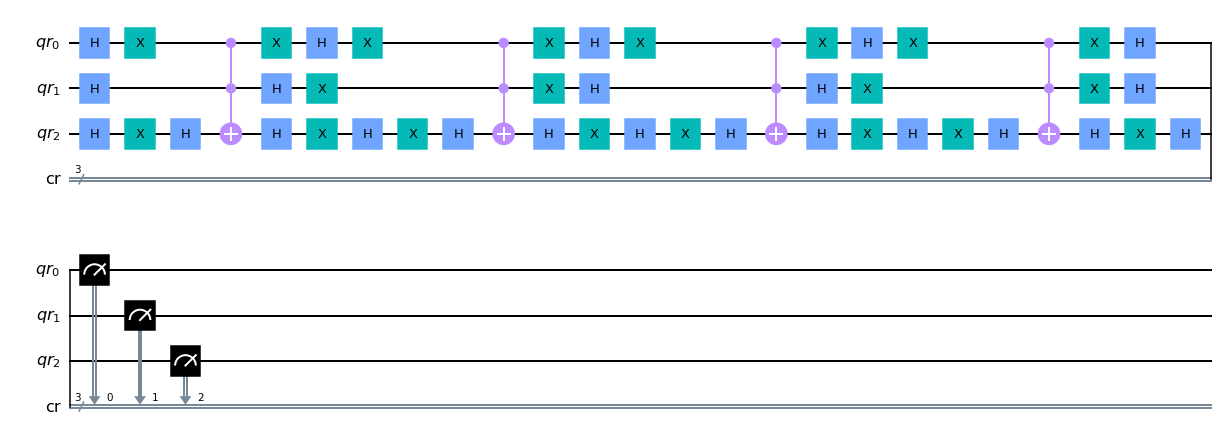

In [10]:
qc_Grov.measure(qr,cr)
qc_Grov.draw(output='mpl')

## Simulações de fases no circuito

Para agora verificarmos as propriedades descritas no algoritmo enunciado, serão simuladas as *phases* em cada iteração do oráculo e difusor,isto é, na etapa de "seleção" e "amplificação" de fase.

Será executada a função utilizada na geração do circuito apresentado, com o parâmetro `phaseTests = True`:

In [11]:
nBits=3
handle = oracleHandler(nBits)
qr = QuantumRegister(nBits,'qr')
cr = ClassicalRegister(nBits,'cr')
qc_PhaseTest = QuantumCircuit(qr,cr)
qc_PhaseTest.h(qr)


tests = handle(qc_PhaseTest,qr,pattern= '010', phaseTests=True)

Generating Oracle Handler to circuit with 3 QBits...

Recomended 2 applications of the Gate...

0 auxiliar QBits required to execute circuit...

- returned:
 λ(circuit,QBits,pattern='111',app=2, phaseTests=False)

Grover Algorithm applied 2 times...
 To search for 010...



A variável `tests` apresentará então uma lista de tuplos `(etapa,estado)`, em que "etapa" corresponde ao identificador do passo dado, e "estado" a medição da fase após a execução da etapa.

Iremos então verificar um a um os *steps* de execução:

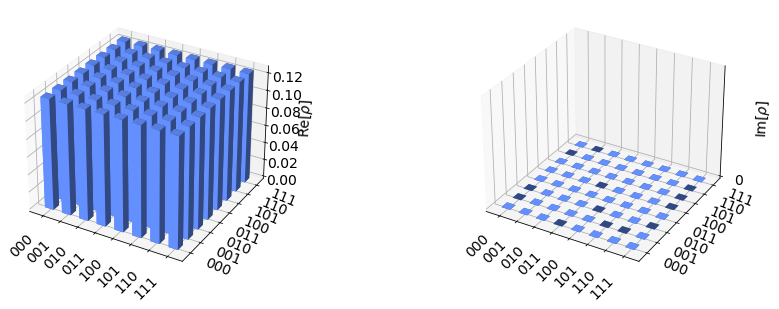

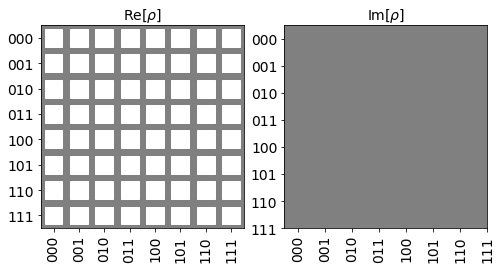

In [12]:
(step,state) = tests.pop(0)
display(HTML(f'<h1>{step}</h1>'))
display(plot_state_city(state))
display(plot_state_hinton(state))

A medição apresentada acima trata-se do estado inicial do circuito,em que os fatores encontram-se todos igualmente distribuídos, A seguir apresentamos as *phases* após a aplicação do primeiro oráculo.

Como descrito anteriormente, nesta aplicação, a *phase* será invertida para valores correspondentes com o pattern procurado:

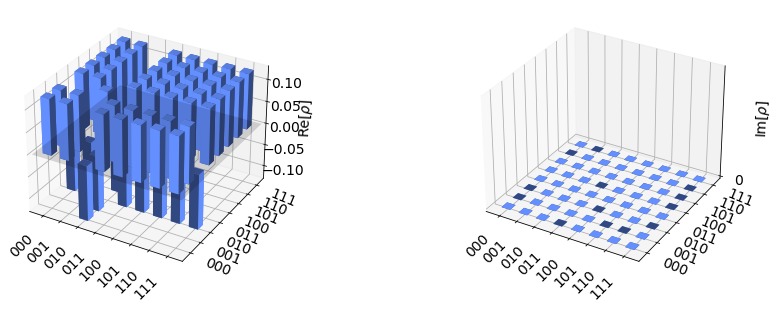

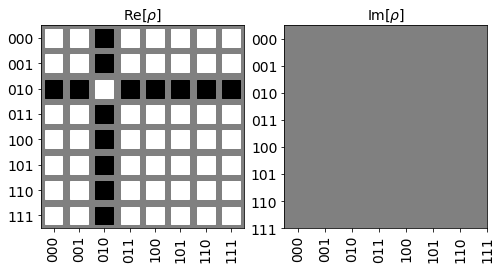

In [13]:
(step,state) = tests.pop(0)
display(HTML(f'<h1>{step}</h1>'))
display(plot_state_city(state))
display(plot_state_hinton(state))

Em seguida, é aplicado o difusor, verificaremos então o comportamento requerido na especificação. 
Isto é, o fator a ser selecionado deve ser reinvertido e ampliado.

Verifiquemos:

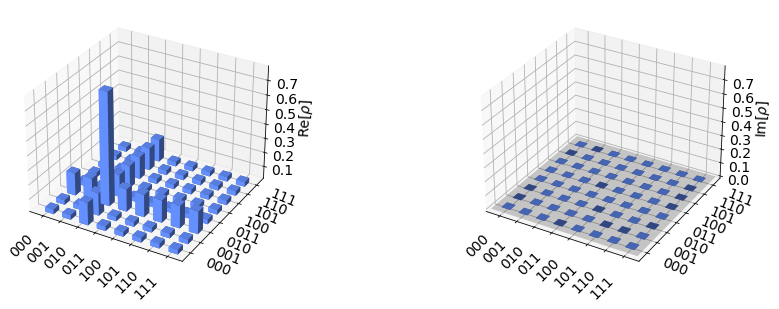

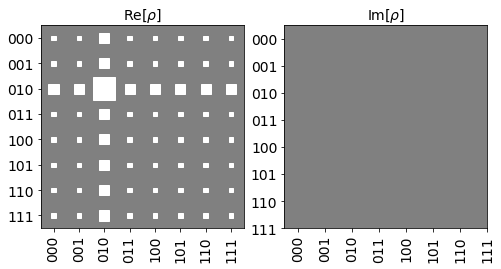

In [14]:
(step,state) = tests.pop(0)
display(HTML(f'<h1>{step}</h1>'))
display(plot_state_city(state))
display(plot_state_hinton(state))

As aplicações apresentadas são então repetidas, iteremos então sobre o final da lista apresentada, para verificarmos o bom funcionamento das iterações seguintes:

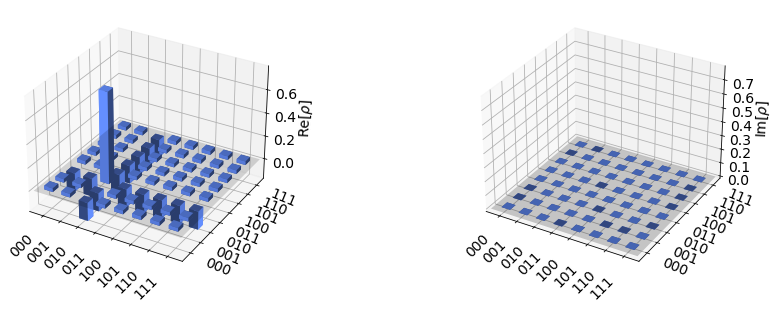

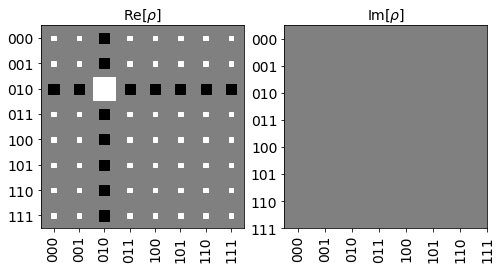

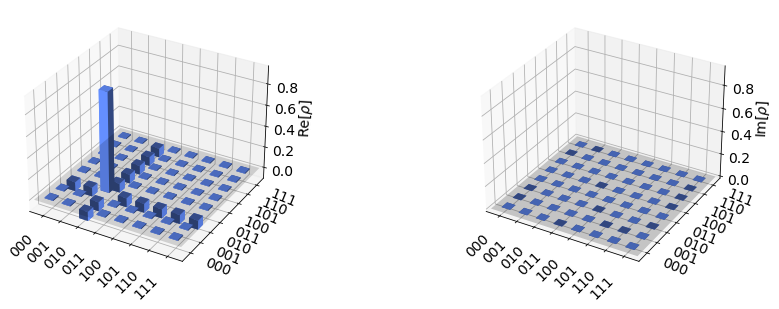

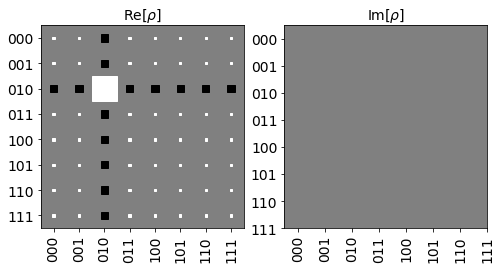

In [15]:
for (step,state) in tests:
    display(HTML(f'<h1>{step}</h1>'))
    display(plot_state_city(state))
    display(plot_state_hinton(state))

## Simulação do circuito apresentado

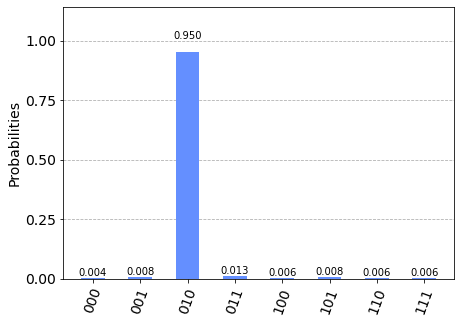

In [16]:
backend = Aer.get_backend("qasm_simulator")
shots=1024
result = execute(qc_Grov, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grov)
plot_histogram(counts_sim)

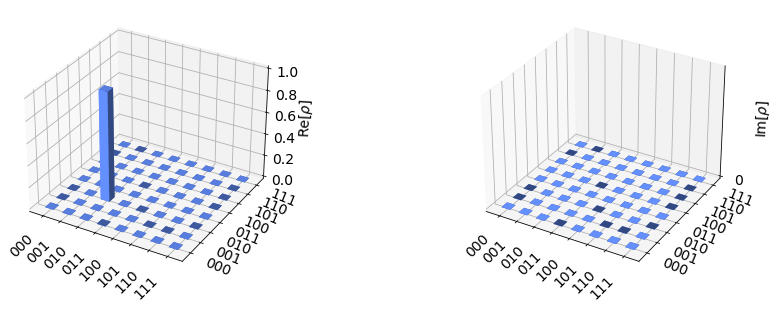

In [17]:
backend_state = Aer.get_backend('statevector_simulator')
result = execute(qc_Grov, backend_state).result()
state  = result.get_statevector(qc_Grov)
plot_state_city(state)

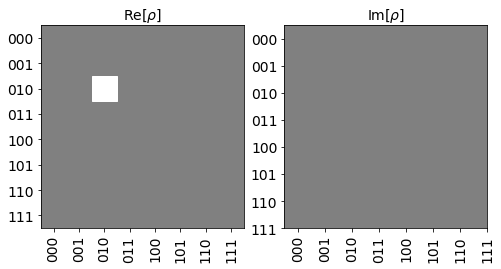

In [18]:
plot_state_hinton(state)

## Testes em *Real Devices*

Para então utilizarmos o circuito na prática, podemos escolher um *backend* da IBM para realizar a aplicação.

In [19]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [20]:
import qiskit.tools.jupyter

%qiskit_backend_overview

### Escolha do Device

In [21]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                  ibmq_belem
-----------                  ----------                  ----------
Num. Qubits:  5              Num. Qubits:  5             Num. Qubits:  5
Pending Jobs: 23             Pending Jobs: 7             Pending Jobs: 9
Least busy:   False          Least busy:   True          Least busy:   False
Operational:  True           Operational:  True          Operational:  True
Avg. T1:      169.0          Avg. T1:      85.7          Avg. T1:      73.7
Avg. T2:      62.0           Avg. T2:      77.5          Avg. T2:      82.0



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 10             Pending Jobs: 10             Pending Jobs: 10
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  

O *device* escolhido tratou-se do `ibmq_santiago`.
Para realizar a escolha, procuramos equilibrar a taxa de erro dos gates $cX$ de grande importância no algoritmo apresentado, com as medidas de T1 e T2, e com o tamanho da *queue* de *jobs*. 

O `ibmq_santiago` possuia uma fila pequena, com taxas de erros aceitáveis, logo fora o escolhido. A segunda opção viria a ser `ibmq_athens`, mas este apresentava uma taxa de erro elevada de $cX$ em alguns pares de QBits. 

O `ibmq_athens`, entretanto, possuía menores medições de T1 e T2, o que, por exeperiências passadas colocou o grupo em dúvida na escolha entre tais *devices*.

O T1 corresponde ao tempo que o ruído leva para alterar o estado de um qubit aleatoriamente (por exemplo de $|0\rangle$ para $|1\rangle$), enquanto o T2 corresponde ao tempo que o ruído leva para alterar a amplitude de cada uma das bases de um qubit em sobreposição, podendo assim causar um enviesamento para um determinado estado. 

Assim o T2, que possui maior impacto na amplitude (de muita importância no algoritmo apresentado), seria o *target* (entre T1 e T2) na escolha (entre Santiago e Athens). 

Levando em conta a última informação, optamos pelo `ibmq_santiago` devido à diferença entre o T2 dos dois *backends* em questão, não ser tanta comparada à diferença no erro dos *gates* $cX$.

A seguir apresentamos informações acerca dos dois dispositivos em questão.

In [22]:
backend_device = provider.get_backend('ibmq_santiago')
print("Running on: ", backend_device)

Running on:  ibmq_santiago


In [25]:
backend_monitor(backend_device)

ibmq_santiago
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 8
    backend_version: 1.3.22
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    meas_kernels: ['hw_qmfk']
    discriminators: ['quadratic_discriminator', 'hw_qmfk', 'linear_discriminator']
    url: None
    meas_levels: [1, 2]
    n_registers: 1
    credits_required: True
    conditional_latency: []
    memory: True
    dynamic_reprate_enabled: True
    allow_q_object: True
    sample_name: family: Falcon, revision: 4, segment: L
    coupling_map: [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
    hamiltonian: {'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_

In [44]:
backend_monitor(provider.get_backend('ibmq_athens'))

ibmq_athens
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 10
    backend_version: 1.3.19
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    meas_kernels: ['hw_qmfk']
    discriminators: ['quadratic_discriminator', 'hw_qmfk', 'linear_discriminator']
    url: None
    meas_levels: [1, 2]
    n_registers: 1
    credits_required: True
    conditional_latency: []
    memory: True
    dynamic_reprate_enabled: True
    allow_q_object: True
    sample_name: family: Falcon, revision: 4, segment: L
    coupling_map: [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
    hamiltonian: {'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{

In [26]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

## Resultados

In [27]:
job_r = execute(qc_Grov, backend_device, shots=shots)
jobID_r = job_r.job_id()
print(f'JOB ID: {jobID_r}')

JOB ID: 60b8e4b19acb6d21ddcc4c0f


In [28]:
job_get=backend_device.retrieve_job("60b8e4b19acb6d21ddcc4c0f")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grov)

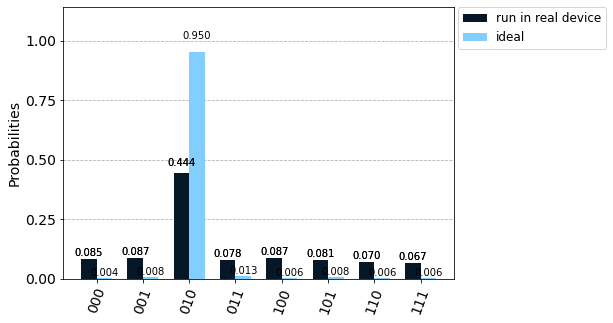

In [29]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

## Variante do circuito

Além do resultado apresentado, acreditávamos ser possível diminuir a taxa de erro diminuindo a depth do circuito e reduzindo probabilidades de ruído. Apresenta-se então o mesmo circuito realizado no tópico anterior, mas com a aplicação de uma única iteração do algoritmo. 

In [30]:
qr = QuantumRegister(nBits,'qr')
cr = ClassicalRegister(nBits,'cr')
qc_Grov = QuantumCircuit(qr,cr)
_ = qc_Grov.h(qr)

In [31]:
_ = handle(qc_Grov,qr,pattern= '010',app=1)

Grover Algorithm applied 1 times...
 To search for 010...



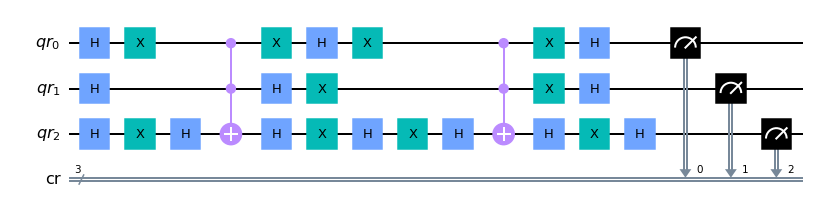

In [32]:
qc_Grov.measure(qr,cr)
qc_Grov.draw(output='mpl')

In [33]:
job_r = execute(qc_Grov, backend_device, shots=shots)
jobID_r = job_r.job_id()
print(f'JOB ID: {jobID_r}')

JOB ID: 60b8e4e50731dfe980bde1b3


In [34]:
job_get=backend_device.retrieve_job("60b8e4e50731dfe980bde1b3")

result_r = job_get.result()
countsRunSingleGate = result_r.get_counts(qc_Grov)

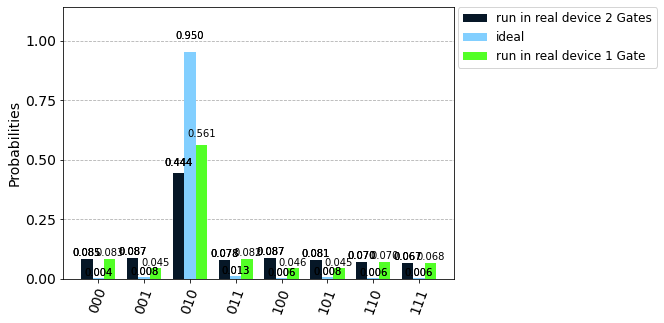

In [35]:
plot_histogram([counts_run, counts_sim, countsRunSingleGate ], \
               legend=[ 'run in real device 2 Gates', 'ideal','run in real device 1 Gate'], \
               color=['#061727','#82cfff','#52ff26'])

## Mitigação de Erros de medida com IGNIS

Os dispositivos quânticos que estamos a utilizar têm ruído, o que influencia o funcionamento do nosso circuito quântico.
A título de exmplo, podemos citar os já referidos T1 e T2.

Para mitigar o ruído em medições podemos utilizar calibrações próprias. O IGNIS providencia-nos as ferramentas necessárias para fazermos estas calibrações e produzir um filtro de mitigação para o ruído nas medições.


In [36]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

Começamos por gerar uma lista de circuitos de calibração de medições, um para cada estado possível no nosso circuito. Como estamos a utilizar $3$ qubits, vamos precisar de $2^{3}$ circuitos de calibração.


In [37]:
qr = QuantumRegister(nBits)

meas_calibs, state_labels = complete_meas_cal(qubit_list=list(range(nBits)), qr=qr, circlabel='mcal')

In [38]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)
jobID_run_ignis = job_ignis.job_id()

print(f'JOB ID: {jobID_run_ignis}')

JOB ID: 60b8e5259acb6d80d2cc4c17


In [39]:
job_get=backend_device.retrieve_job("60b8e5259acb6d80d2cc4c17")

cal_results = job_get.result()

omo estamos a correr o nosso circuito num dispositivo quântico real vai existir ruído, pelo que a matriz de calibração será diferente da identidade. Procedemos ao cálculo desta matriz:



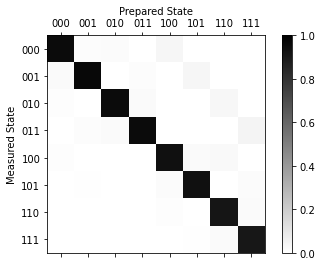

In [40]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

In [41]:
print(f"Average Measurement Fidelity: {meas_fitter.readout_fidelity()*100: .2f}%")

Average Measurement Fidelity:  94.10%


De seguida aplicamos o filtro de mitigação produzido aos resultados que obtivemos nos dispositivos quânticos:

In [42]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

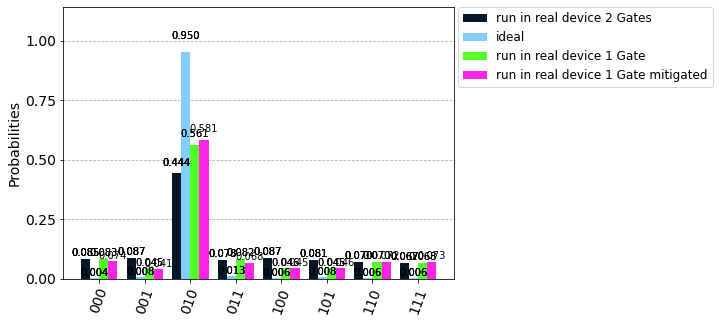

In [43]:
plot_histogram([counts_run, counts_sim, countsRunSingleGate,mitigated_counts ], \
               legend=[ 'run in real device 2 Gates', 'ideal','run in real device 1 Gate','run in real device 1 Gate mitigated' ], \
               color=['#061727','#82cfff','#52ff26', '#ff24e5'])

## Demonstração da função geradora

A seguir, fazemos então apenas uma pequena demonstração da função de ordem superior desenvolvida.

Tomaremos um circuito de $8$ QBits e procuraremos por um padrão escolhido aleatóriamente.
Novamente recorreremos a função de ordem superior para retornar um gerador do algoritmo para circuitos de $N$ QBits, e de seguida aplicaremos o padrão a ser procurado.

O número ideal de procuras foi apontado como $16$, foi entretanto escolhida a aplicação de $11$ iterações.

Generating Oracle Handler to circuit with 8 QBits...

Recomended 16 applications of the Gate...

5 auxiliar QBits required to execute circuit...

- returned:
 λ(circuit,QBits,pattern='11111111',app=16, auxQBits=None, phaseTests=False)

Grover Algorithm applied 11 times...
 To search for 01000101...

higher: 01000101


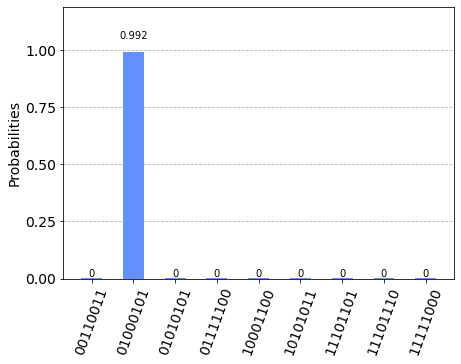

In [37]:
nBits = 8

handle = oracleHandler(nBits)
qr = QuantumRegister(nBits,'qr')
cr = ClassicalRegister(nBits,'cr')
qrAux = QuantumRegister(nBits-3,'qrA')
qc_Grov = QuantumCircuit(qr,qrAux,cr)
qc_Grov.h(qr)

print("===================================")

handle(qc_Grov,qr,pattern= '01000101',auxQBits=qrAux,app=11)
qc_Grov.measure(qr,cr)

print("===================================")

backend = Aer.get_backend("qasm_simulator")
shots=1024
result = execute(qc_Grov, backend, shots=shots).result()

counts_sim = result.get_counts(qc_Grov)
print("higher:",max(counts_sim.keys(), key=lambda t: counts_sim[t]))
plot_histogram(counts_sim)

A execução teórica foi um sucesso. A execução real entretanto torna-se inviável como descrito a seguir.
O circuito é muito profundo, suficiente para que não seja possível a execução em um dispositivo real.

In [9]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.compiler import transpile

transpile_circuit = transpile(qc_Grov, basis_gates=['u3', 'cx'] )
dag_circuit = circuit_to_dag(transpile_circuit)
dag_circuit.count_ops_longest_path()

{'u3': 991, 'cx': 1122, 'measure': 1}

In [8]:
qc_Grov.depth()

310

## Exemplo

A seguir, entretanto, apresenta-se gráficamente um circuito resultante de uma única iteração das $11$ acima requeridas.

Generating Oracle Handler to circuit with 8 QBits...

Recomended 16 applications of the Gate...

5 auxiliar QBits required to execute circuit...

- returned:
 λ(circuit,QBits,pattern='11111111',app=16, auxQBits=None, phaseTests=False)

Grover Algorithm applied 1 times...
 To search for 01000101...



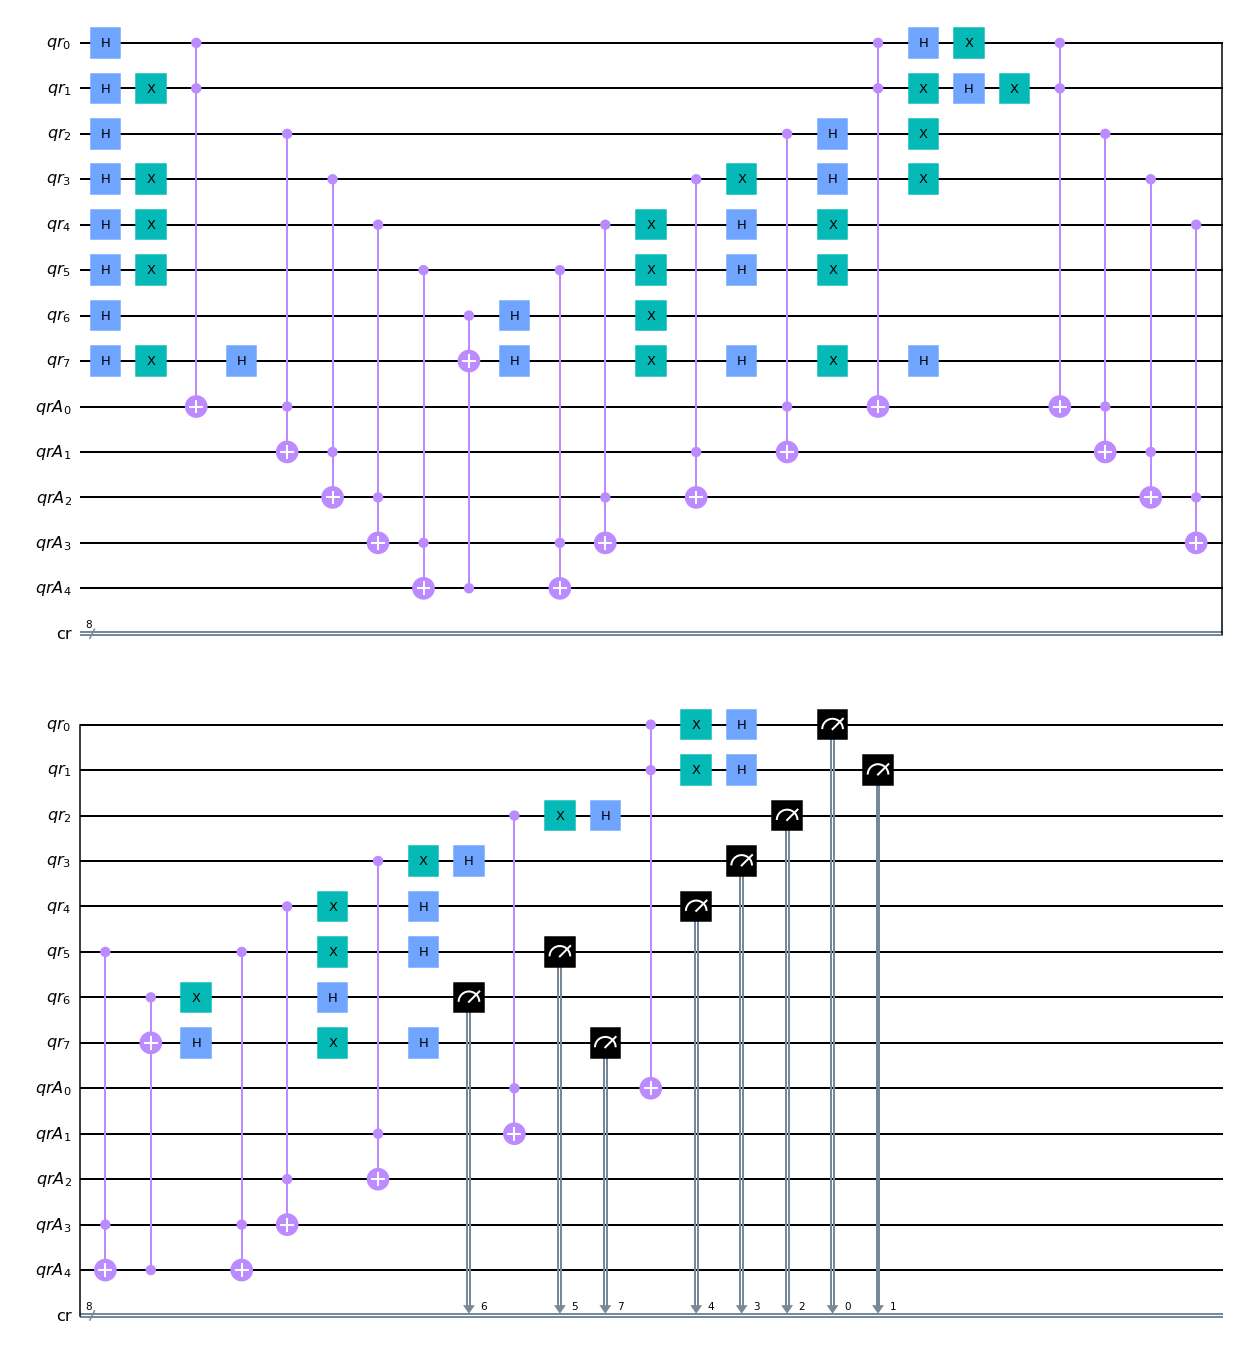

In [38]:
handle = oracleHandler(nBits)
qr = QuantumRegister(nBits,'qr')
cr = ClassicalRegister(nBits,'cr')
qrAux = QuantumRegister(nBits-3,'qrA')
qc_Grov = QuantumCircuit(qr,qrAux,cr)
qc_Grov.h(qr)

print("===================================")

handle(qc_Grov,qr,pattern= '01000101',auxQBits=qrAux,app=1)
qc_Grov.measure(qr,cr)

qc_Grov.draw(output='mpl')